## **Implementação dos Controladores Proporcional e Proporcional Integral para o sitema Motor/Gerador**

Laboratório de controle - 2023.2\
Turma: T03

Coordenador: Cleison Silva

<br>

Grupo 4:

Andrez Muller Miranda Barreto\
Matrícula: 201833940007

Oséias Dias de Farias\
Matrícula: 201733940002

Thalia Damasceno Barroso\
Matrícula: 201633940040

Hebert Barroso\
Matrícula: 201733940007

<br>

---

# **Revisão Teórica**


# Controlador Proporcional
Função de transferência do controlador, 

$$G_c (s) = \frac{U(s)}{E(s)} = K_p $$

Logo o sinal de controle é proporcional ao erro de controle.

No domínio de tempo discreto, temos, 

$$ u(k) = K_p e(k)$$

Lembre-se de que o controlador foi projetado para um ponto de operação, logo para calcular o erro de contorle, deve remover o valor correspondente ao ponto de operação na saída, 

$y(k)$ = sinal_medido - valor_ponto_operação
$$e(k) = r(k) - y(k)$$




### **Implementação do Controlador P e gravação os dados dos sinais do sistema**

```python

"""
Bancada Motor-Gerador
UFPA - Campus Tucuruí
Monitoria de Sistemas de Controle para Engenharia - PGRAD - MONITORIA 03/2020
Coodenador: Cleison Daniel Silva
Bolsista: Felipe Silveira Piano
Data: 27/09/2020
"""

# gerenciador de dispositivo - encontrar porta COM

# from pyserial import Serial
import numpy as np
import matplotlib.pyplot as plt            # noqa: F401
import time as t
from scipy.signal import square, sawtooth  # noqa: F401
import serial

##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15

numAmostras = 400
tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras)

Ts = 0.02

fre = 0.5
Amplitude = 0.5
ponto_de_operacao = 0

nivel_dc_saida = 2.266

r = np.zeros(numAmostras)
u = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
# #####################

for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts)

print('\nEstabelecendo conexão.')
# Linux: port='/dev/ttyACM0'
conexao = serial.Serial(port='COM8', baudrate=9600, timeout=0.005)

t.sleep(1)
print('\nIniciando coleta.')

# #_____________ Loop principal de controle _____________##
nivel_dc_entrada = 7.5

# Ganho do Controlador Proporcional
# Kp = 2.296  # Valor de projeto
Kp = 5.5

for n in range(numAmostras):
    tic = t.time()
    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()

    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    # calcula o erro
    e = r[n] - sinal_medido

    # primeiras 50 amostras
    if (n < 50):
        u[n] = nivel_dc_entrada
        r[n] = 0.0
    else:
        u[n] = (Kp*e) + nivel_dc_entrada

    if (u[n] > amplitude_maxima):
        sinal_PWM = 255
    else:
        sinal_PWM = ((u[n])*255)/amplitude_maxima
    # sinal_PWM deve ser um número inteiro entre 0 e 255
    conexao.write(str(round(sinal_PWM)).encode())
    t.sleep(Ts)

    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic

conexao.write('0'.encode())
print('\nFim da coleta.')
conexao.close()

print('media=', np.mean(r))

print('\nPeríodo real:', np.mean(toc))
print('Nivel_DC:', np.mean(y[tempo > 2]))

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(tempo, u, '-b', linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Tensão (V)')
plt.grid()
plt.title('Onda Quadrada - Malha Aberta')
plt.legend(loc='lower right', labels=('Sinal de Entrada', 'Sinal de Saída'))

plt.subplot(212)
plt.plot(tempo, r + nivel_dc_saida, '-b', tempo, y, '-r', linewidth=1.2)
# plt.plot(tempo, y, '-ro', linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Tensão (V)')
plt.grid()
# plt.title('Tensão de Saída - Malha Aberta')
plt.show()

dados = np.stack((tempo, r, y), axis=-1)

r_ofessert = r + nivel_dc_saida

dados = np.stack((tempo, r, y, u, r_ofessert), axis=-1)

np.savetxt("controle_P_dados_motorgerador.csv", dados, delimiter=";")

```

**Importando Bibliotecas usadas**

In [46]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
import scipy.signal as sg
from control.matlab import *
import scienceplots

%config InlineBackend.figure_format='retina'
plt.style.use(["science", "notebook"])

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

### Dados em Malha Aberta

In [47]:
dados_malha_aberta = pd.read_csv("dados/50pc_dados_motorgerador.csv",
                                 header = None, sep=';').values
dados_malha_aberta

array([[0.  , 8.5 , 0.  ],
       [0.02, 8.5 , 0.  ],
       [0.04, 8.5 , 0.  ],
       ...,
       [7.94, 6.5 , 2.11],
       [7.96, 6.5 , 2.1 ],
       [7.98, 6.5 , 2.11]])

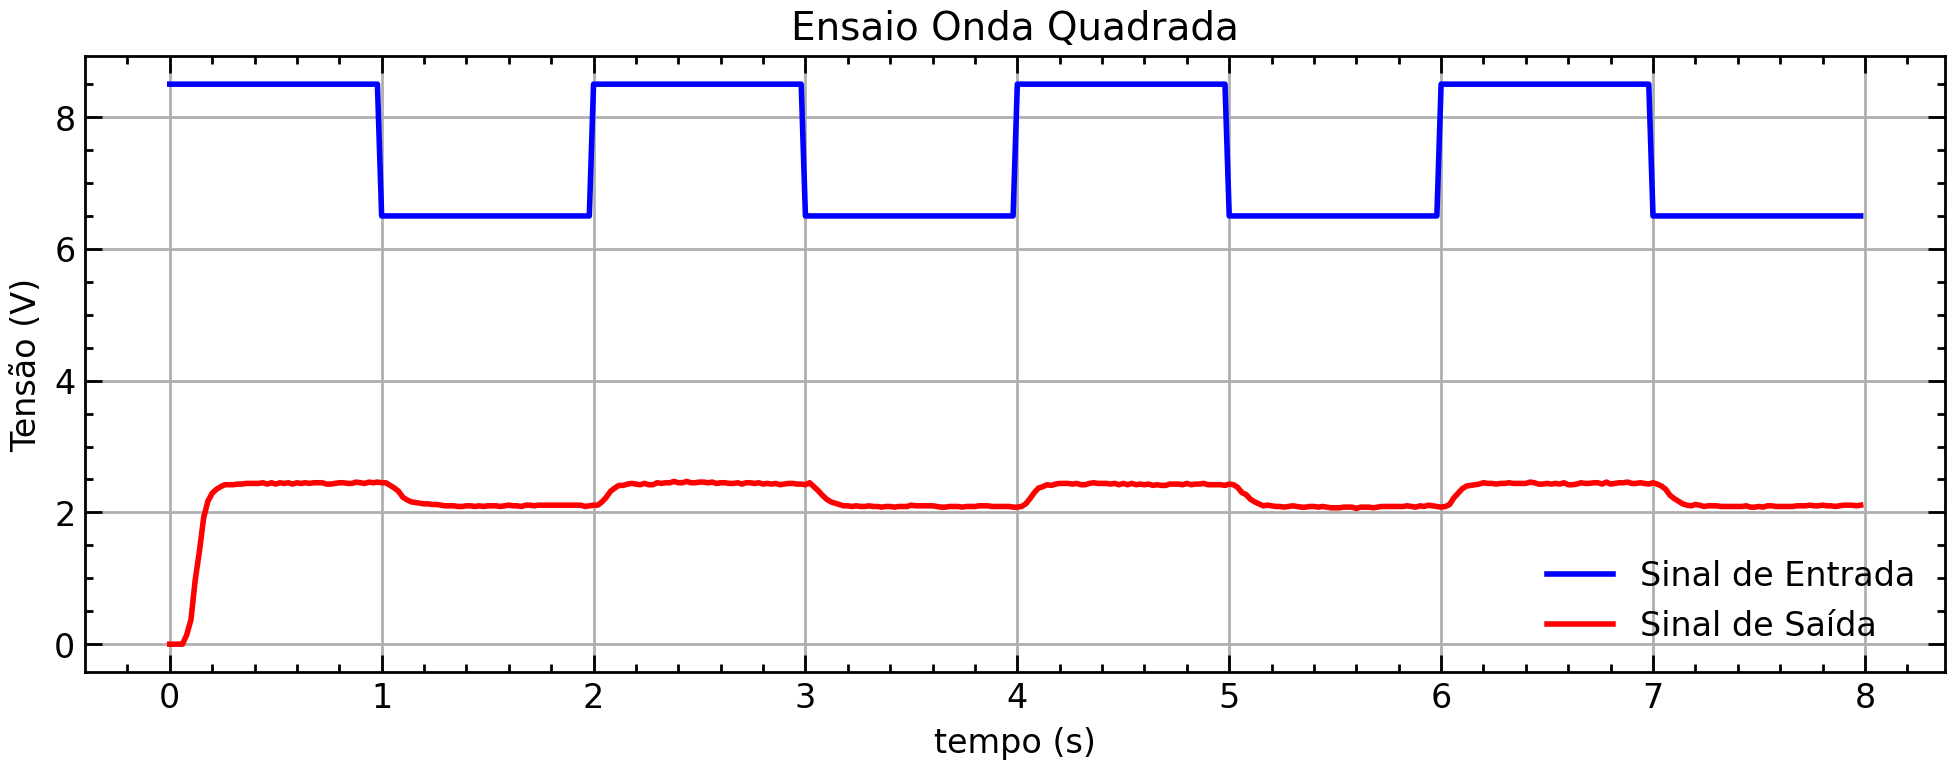


 Periodo de Amostragem: 0.02


In [48]:
# Dados
tempo = np.array(dados_malha_aberta[:,0])
sinal_entrada  = np.array(dados_malha_aberta[:,1])
sinal_saida = np.array(dados_malha_aberta[:,2])

plt.figure(figsize=(12, 4))
plt.plot(tempo, sinal_entrada, c = 'b', label = "Sinal de Entrada")
plt.plot(tempo, sinal_saida, c = 'r', label = "Sinal de Saída")

plt. title('Ensaio Onda Quadrada', fontsize=14)
plt.ylabel('Tensão (V)', fontsize=12)
plt.xlabel('tempo (s)', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

Ts = 0.02
print('\n','Periodo de Amostragem:', Ts)

### Dados em Malha Fechada Controlador Proporcional

In [49]:
#___________Código para Calcular o Kp ___________#

Km = 0.18666
tau = 0.090833

perc = 7/10

Kp = (1/perc - 1)/Km

print("\nGanho Proporcional: ", Kp)

Ganho = (Km*Kp)/(1+Kp*Km)

print("Ganho DC: ", Ganho)


Ganho Proporcional:  2.296000367360059
Ganho DC:  0.3


In [50]:
dados_malha_fechada_p = pd.read_csv("dados/controle_P_dados_motorgerador.csv",
                                    header = None, sep=';').values
dados_malha_fechada_p

array([[ 0.   ,  0.   ,  0.   ,  7.5  ,  2.266],
       [ 0.02 ,  0.   ,  0.   ,  7.5  ,  2.266],
       [ 0.04 ,  0.   ,  0.05 ,  7.5  ,  2.266],
       ...,
       [ 7.94 , -0.5  ,  2.07 ,  5.828,  1.766],
       [ 7.96 , -0.5  ,  2.06 ,  5.883,  1.766],
       [ 7.98 , -0.5  ,  2.04 ,  5.993,  1.766]])

In [51]:
# Dados
tempo_controle_p = np.array(dados_malha_fechada_p[:,0])
referencia_controlador_p  = np.array(dados_malha_fechada_p[:,1])
sinal_saida_controlador_p = np.array(dados_malha_fechada_p[:,2])
sinal_controle_controlador_p = np.array(dados_malha_fechada_p[:,3])
referencia_offeset_controlador_p = np.array(dados_malha_fechada_p[:,4])

In [52]:
num = [Km]
den = [tau, 1.]

Gs = ct.tf(num, den)

# Ganho do Controlador testado na bancada
Kp = 5.5
Gc = Kp

# # ________Sistema em Malha Fechada __________##
H = ct.feedback(Gc*Gs, 1, sign = -1)
print("Sistema em Malha Fechada:\n", H)

# # ________Simulação do Sistema em Malha Fechada para Onda Quadrada __________##
_, y_malha_fechada = ct.forced_response(H, T=tempo_controle_p,
                                        U=referencia_controlador_p)

## ________Sistema para Obter Sinal de Controle __________##
C = ct.feedback(Gc, Gs, sign =-1)
print("Sinal de Controle:\n", C)

## ________Simulação para obter o Sinal de Controle __________##
_, sinal_controle = ct.forced_response(C, T=tempo_controle_p, U=referencia_controlador_p)

Sistema em Malha Fechada:
 
      1.027
-----------------
0.09083 s + 2.027

Sinal de Controle:
 
 0.4996 s + 5.5
-----------------
0.09083 s + 2.027



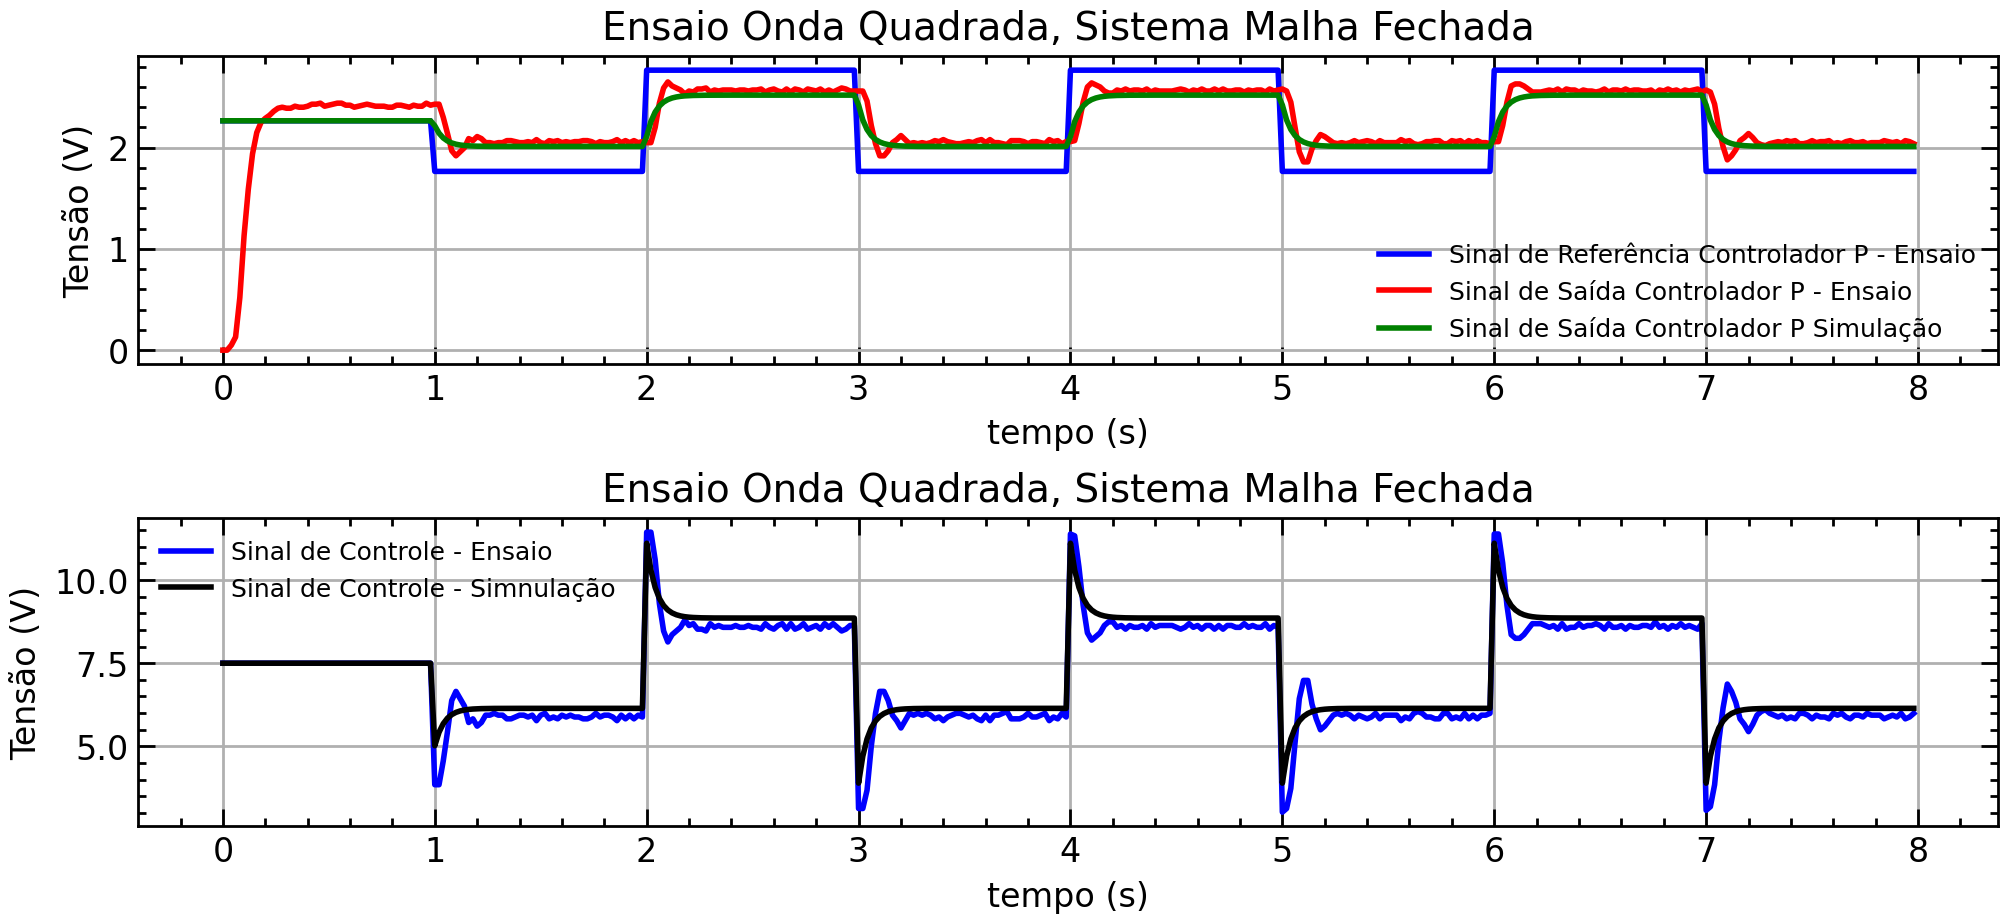


 Periodo de Amostragem: 0.02


In [53]:
plt.figure(figsize=(12, 5))
plt.subplot(211)
plt.plot(tempo_controle_p, referencia_offeset_controlador_p,
         c='b', label="Sinal de Referência Controlador P - Ensaio")
plt.plot(tempo_controle_p, sinal_saida_controlador_p,
         c='r', label= "Sinal de Saída Controlador P - Ensaio")
plt.plot(tempo_controle_p, y_malha_fechada + 2.266,
         c='g', label="Sinal de Saída Controlador P Simulação")

plt. title('Ensaio Onda Quadrada, Sistema Malha Fechada', fontsize=14)
plt.ylabel('Tensão (V)', fontsize=12)
plt.xlabel('tempo (s)', fontsize=12)
plt.legend(fontsize=9)
plt.grid()

plt.subplot(212)
plt.plot(tempo_controle_p, sinal_controle_controlador_p,
         c = 'b', label = "Sinal de Controle - Ensaio")
plt.plot(tempo_controle_p, sinal_controle + 7.5,
         c = 'black', label = "Sinal de Controle - Simnulação")

plt. title('Ensaio Onda Quadrada, Sistema Malha Fechada', fontsize=14)
plt.ylabel('Tensão (V)', fontsize=12)
plt.xlabel('tempo (s)', fontsize=12)
plt.legend(fontsize=9)
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.show()

Ts = 0.02
print('\n','Periodo de Amostragem:', Ts)

---

# Controlador PI

Função de Transferência de Controlador PI:

$$ G_c (s) = \frac{K_c (s + a)}{s} \tag{B}$$

Discretização para $T_s$, período de amostragem. 

1. Forward Differences
$$G_c(z) = G_c(s)|_{s = \frac{z - 1}{T_s}}$$
2. Backwards Differences
$$G_c(z) = G_c(s)|_{s = \frac{1}{T_s} \frac{z - 1}{z}}$$
3. Trapezoidal (Tustin)
  $$G_c(z) = G_c(s)|_{s = \frac{2}{T_s} \frac{z - 1}{z + 1}}$$

No domínio $z$, temos, 
$$\frac{U(z)}{E(z)} = \frac{b_0 z + b_1}{z - 1} \frac{z^{-1}}{z^{-1}} $$


no tempo discreto, a Equação de Diferenças:

$$ u(k) = u(k-1) + b_0 e(k) + b_1 e(k-1)$$ 


### **Implementação do Controlador PI e gravação os dados dos sinais do sistema**


```python

"""
Bancada Motor-Gerador
UFPA - Campus Tucuruí
Monitoria de Sistemas de Controle para Engenharia - PGRAD - MONITORIA 03/2020
Coodenador: Cleison Daniel Silva
Bolsista: Felipe Silveira Piano
Data: 27/09/2020
"""

# gerenciador de dispositivo - encontrar porta COM

# from pyserial import Serial
import numpy as np
import matplotlib.pyplot as plt            # noqa: F401
import time as t
from scipy.signal import square, sawtooth  # noqa: F401
import serial

##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15

numAmostras = 400
tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras)
e = np.zeros(numAmostras)

Ts = 0.02

fre = 0.5
Amplitude = 0.5
ponto_de_operacao = 0

nivel_dc_saida = 2.266

r = np.zeros(numAmostras)
u = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
# #####################

for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts)

print('\nEstabelecendo conexão.')
# port='/dev/ttyACM0'
conexao = serial.Serial(port='COM8', baudrate=9600, timeout=0.005)

t.sleep(1)
print('\nIniciando coleta.')

# _____________ Loop principal de controle _____________#
nivel_dc_entrada = 7.5

# Ganho do Controlador Proporcional
for n in range(numAmostras):
    tic = t.time()
    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()

    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    # calcula o erro
    e[n] = r[n] - sinal_medido

    # primeiras 50 amostras
    if (n < 50):
        u[n] = nivel_dc_entrada
        r[n] = 0.0
    else:
        u[n] = (u[n-1] + 2.404*e[n] - 1.331*e[n-1])
        # print("Valor de (Kp*e)", (Kp*e))

    if (u[n] > amplitude_maxima):
        # print("Valor de u[n]", u[n])
        sinal_PWM = 255
    else:
        sinal_PWM = ((u[n])*255)/amplitude_maxima
        sinal_PWM += 127
    # sinal_PWM deve ser um número inteiro entre 0 e 255

    conexao.write(str(round(sinal_PWM)).encode())
    # print("Sinal Controle PWM: ", sinal_PWM)
    t.sleep(Ts)

    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic

conexao.write('0'.encode())
print('\nFim da coleta.')
conexao.close()

print('media=', np.mean(r))

print('\nPeríodo real:', np.mean(toc))
print('Nivel_DC:', np.mean(y[tempo > 2]))

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(tempo, u, '-b', linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Tensão (V)')
plt.grid()
plt.title('Onda Quadrada - Malha Aberta')
plt.legend(loc='lower right', labels=('Sinal de Entrada', 'Sinal de Saída'))

plt.subplot(212)
plt.plot(tempo, r + nivel_dc_saida, '-b', tempo, y, '-r', linewidth=1.2)
# plt.plot(tempo, y, '-ro', linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Tensão (V)')
plt.grid()
# plt.title('Tensão de Saída - Malha Aberta')
plt.show()

r_ofessert = r + nivel_dc_saida

dados = np.stack((tempo, r, y, e, u, r_ofessert), axis=-1)
np.savetxt("controle_PI_dados_motorgerador.csv", dados, delimiter=";")


```

### Dados em Malha Fechada Controlador Proporcional

In [54]:
dados_malha_fechada_pi = pd.read_csv("dados/controle_PI_dados_motorgerador.csv",
                                    header = None, sep=';').values
dados_malha_fechada_pi

array([[ 0.      ,  0.      ,  0.      ,  2.766   ,  7.5     ,  2.266   ],
       [ 0.02    ,  0.      ,  0.      ,  2.766   ,  7.5     ,  2.266   ],
       [ 0.04    ,  0.      ,  0.06    ,  2.706   ,  7.5     ,  2.266   ],
       ...,
       [ 7.94    , -0.5     ,  1.78    , -0.014   , -2.534986,  1.766   ],
       [ 7.96    , -0.5     ,  1.79    , -0.024   , -2.574048,  1.766   ],
       [ 7.98    , -0.5     ,  1.78    , -0.014   , -2.57576 ,  1.766   ]])